Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shreyaisa","key":"ab7c1165016a558f6b13de88f176ddf4"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d gti-upm/leapgestrecog
!unzip -q leapgestrecog.zip -d leapgest


Dataset URL: https://www.kaggle.com/datasets/gti-upm/leapgestrecog
License(s): CC-BY-NC-SA-4.0
100% 2.12G/2.13G [00:21<00:00, 178MB/s]
100% 2.13G/2.13G [00:21<00:00, 106MB/s]


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
from glob import glob

data_dir = "leapgest"
gesture_classes = sorted(os.listdir(data_dir))
print("Gesture classes:", gesture_classes)

# Count samples in each class
for cls in gesture_classes:
    num_images = len(glob(os.path.join(data_dir, cls, '*.png')))
    print(f"Class {cls}: {num_images} images")


Gesture classes: ['leapGestRecog', 'leapgestrecog']
Class leapGestRecog: 0 images
Class leapgestrecog: 0 images


In [ ]:
import os

# Find where the real class folders are
for root, dirs, files in os.walk('leapgest'):
    if len(dirs) > 5:  # likely class folders (00, 01, ...)
        print("✅ Found gesture folders inside:", root)
        gesture_path = root
        break

# Update class list
gesture_classes = sorted(os.listdir(gesture_path))
print("Classes:", gesture_classes)


✅ Found gesture folders inside: leapgest/leapGestRecog
Classes: ['00', '01', '02', '03', '04', '05', '06', '07', '08', '09']


In [ ]:
import os
from glob import glob
from collections import defaultdict

gesture_path = "leapgest/leapGestRecog"
image_paths = []
image_labels = []

# Map: gesture_name → label ID
label_map = {}
label_counter = 0

# Traverse two levels: ID/gesture_name/*.png
for gesture_id in os.listdir(gesture_path):
    id_path = os.path.join(gesture_path, gesture_id)
    if not os.path.isdir(id_path):
        continue
    for gesture_name in os.listdir(id_path):
        full_path = os.path.join(id_path, gesture_name)
        if not os.path.isdir(full_path):
            continue

        # Assign a label ID if new gesture
        if gesture_name not in label_map:
            label_map[gesture_name] = label_counter
            label_counter += 1

        # Get all .png files
        pngs = glob(os.path.join(full_path, '*.png'))
        image_paths.extend(pngs)
        image_labels.extend([label_map[gesture_name]] * len(pngs))

print("✅ Total images found:", len(image_paths))
print("🔤 Gesture classes:", label_map)


✅ Total images found: 20000
🔤 Gesture classes: {'05_thumb': 0, '02_l': 1, '09_c': 2, '04_fist_moved': 3, '07_ok': 4, '08_palm_moved': 5, '01_palm': 6, '03_fist': 7, '10_down': 8, '06_index': 9}


In [ ]:
from sklearn.model_selection import train_test_split

train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state=42
)


In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# Transform: grayscale resize to 64x64, then normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

class GestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")  # Grayscale
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

# Datasets and Loaders
train_dataset = GestureDataset(train_paths, train_labels, transform=transform)
val_dataset = GestureDataset(val_paths, val_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class GestureCNN(nn.Module):
    def __init__(self, num_classes):
        super(GestureCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 32, 31, 31]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 64, 14, 14]
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# Instantiate model
num_classes = len(set(image_labels))
model = GestureCNN(num_classes).to("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Define device (add if not already defined)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.eval()
correct = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        correct += (predicted == labels).sum().item()

val_acc = correct / len(val_loader.dataset)
print(f"✅ Validation Accuracy: {val_acc:.4f}")



✅ Validation Accuracy: 0.1000


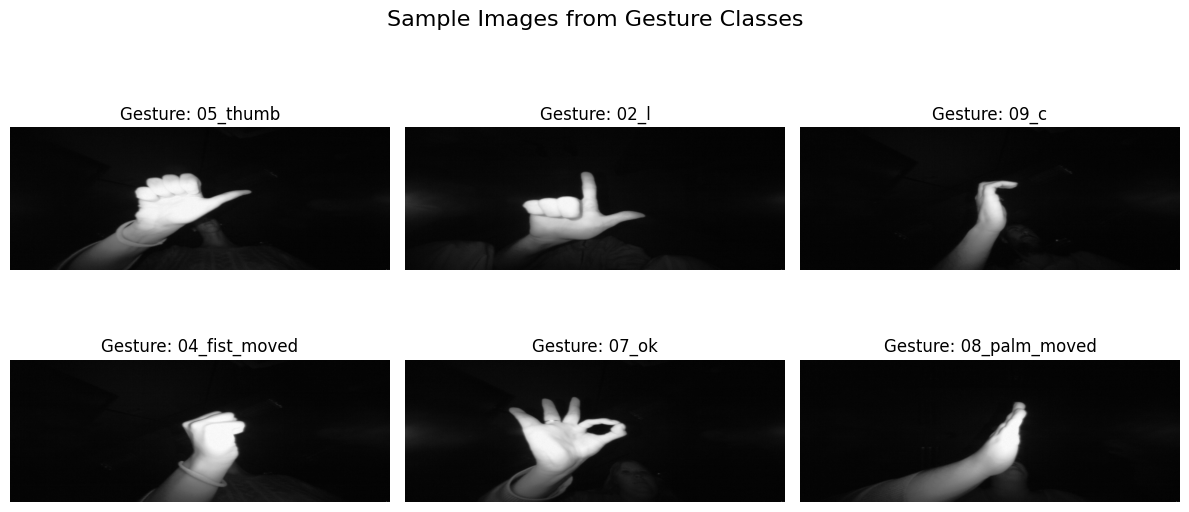

In [ ]:
import matplotlib.pyplot as plt
import cv2
from random import choice

# Pick 6 random gesture classes
plt.figure(figsize=(12, 6))

for i, gesture in enumerate(list(label_map.keys())[:6]):
    # Get a sample image path for the class
    class_paths = [p for p, l in zip(image_paths, image_labels) if label_map[gesture] == l]
    if not class_paths:
        continue
    sample_path = choice(class_paths)

    # Read and display image
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Gesture: {gesture}")
    plt.axis("off")

plt.suptitle("Sample Images from Gesture Classes", fontsize=16)
plt.tight_layout()
plt.show()


Total samples: 20000
Epoch 1, Loss: 219.5485
Epoch 2, Loss: 12.1785
Epoch 3, Loss: 9.2489
Epoch 4, Loss: 7.9511
Epoch 5, Loss: 7.9057
Epoch 6, Loss: 7.4252
Epoch 7, Loss: 6.8152
Epoch 8, Loss: 6.7559
Epoch 9, Loss: 6.5700
Epoch 10, Loss: 12.1872
Accuracy: 97.97%


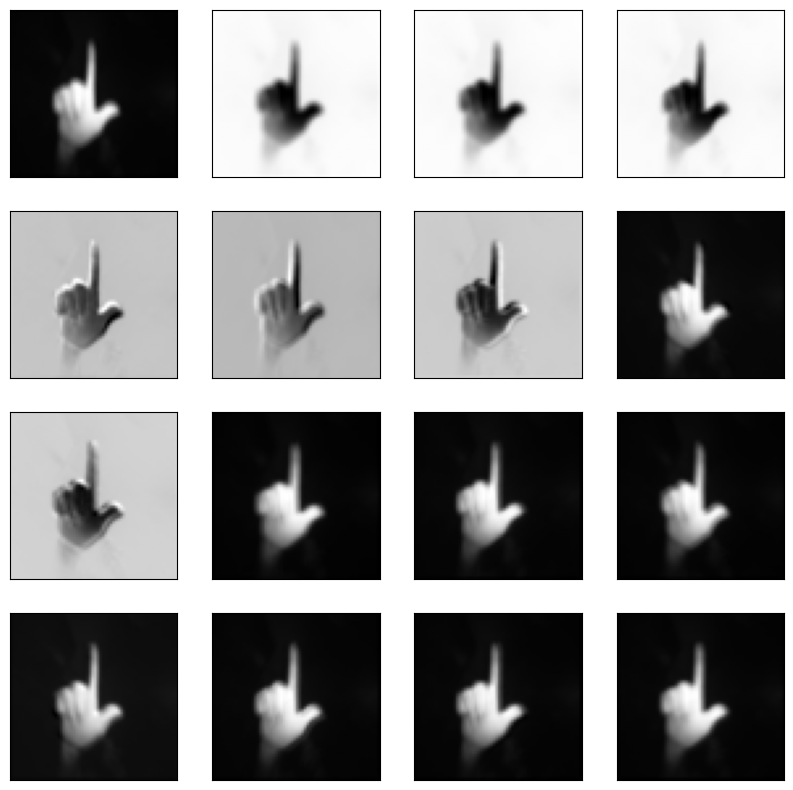

True Label: 06


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
# Update this to your real path after unzipping
data_dir = '/content/leapgest/leapGestRecog'
gesture_classes = sorted(os.listdir(data_dir))

# Load images and labels
image_paths, labels = [], []
for label in gesture_classes:
    class_dir = os.path.join(data_dir, label)
    for img_path in glob(f"{class_dir}/*/*.png"):  # Use subfolders
        image_paths.append(img_path)
        labels.append(label)

print(f"Total samples: {len(image_paths)}")

le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
num_classes = len(le.classes_)
class GestureDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("L")
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label
train_paths, val_paths, y_train, y_val = train_test_split(
    image_paths, encoded_labels, test_size=0.2, stratify=encoded_labels, random_state=42)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

train_dataset = GestureDataset(train_paths, y_train, transform)
val_dataset = GestureDataset(val_paths, y_val, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # -> [32, 16, 16]
        x = x.view(-1, 32 * 16 * 16)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(10):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        predicted = outputs.argmax(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Accuracy: {100 * correct / total:.2f}%")
activation_maps = {}
def get_activation(name):
    def hook(model, input, output):
        activation_maps[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
def show_activation_maps(image_tensor, gray=False):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        model(image_tensor)
    feature_maps = activation_maps['conv1'].cpu().squeeze(0)
    fig = plt.figure(figsize=(10, 10))
    square = 4
    for i in range(min(square**2, feature_maps.size(0))):
        ax = fig.add_subplot(square, square, i + 1)
        ax.set_xticks([]), ax.set_yticks([])
        plt.imshow(feature_maps[i], cmap='gray' if gray else None)
    plt.show()
sample_img = transform(Image.open(val_paths[66]).convert("L"))
show_activation_maps(sample_img, gray=True)
print("True Label:", le.inverse_transform([y_val[66]])[0])
